# Train the StarNet Model

This notebook takes you through the steps of how to train a StarNet Model
- Required Python packages: `numpy h5py keras`
- Required data files: training_data.h5, mean_and_std.npy

Note: We use tensorflow for the keras backend.

In [17]:
import numpy as np
import h5py
import random
import keras
from keras.models import Model
from keras.layers import Input, Dense, InputLayer, Flatten, Reshape, Concatenate, concatenate
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import Adam
import tensorflow as tf
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import HDF5Matrix
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc


#Loading the data

#RVSFlux normalized
pathrvs = 'norm_rvsflux.h5'
readrvs = h5py.File(pathrvs, 'r')
print(readrvs.keys())
rvs = readrvs.get('normrvs')
norm_rvsflux = np.array(rvs)
readrvs.close()

type(rvs)
print('shape of rvsflux:', np.shape(norm_rvsflux))


<KeysViewHDF5 ['normrvs']>
shape of rvsflux: (415, 1134)


In [18]:

#BPFlux
pathbp = 'bpfluxsnr.h5'
readbp = h5py.File(pathbp, 'r')
#print('total number of wave and flux in the folder:'len(readbp.keys()))
bpflux = readbp.get('bpflux0')
bpflux = np.array(bpflux)


norm_bpflux= []

for ii in range(np.shape(norm_rvsflux)[0]):
    #if ii%50 == 0: #i=i/100
        #print('star #',ii)
        fluxlabel = 'bpflux'+str(ii)
        wavelabel = 'bpwave' +str(ii)
        flux = readbp.get(fluxlabel)
        wave= readbp.get(wavelabel)
    
        
        flux = np.array(flux)
        wave = np.array(wave)
        #print('flux is:', flux)
        
        max_flux=np.max(flux)
        #print('maxflux:', max_flux)
        normflux = flux/ max_flux
        #print('normflux:',normflux)
        
        
        
        #plt.plot(wave, flux)
        #plt.scatter(wave,flux, color='red')
        #plt.show()
    
        
        norm_bpflux.append(normflux)


        
norm_bpflux= np.array(norm_bpflux)

print('shape of norm bpflux:', np.shape(norm_bpflux))
#print('shape of norm bpflux:', print(norm_bpflux[0:10]))









shape of norm bpflux: (415, 53)


In [19]:
#RPFlux
pathrp = 'rpfluxsnr.h5'
readrp = h5py.File(pathrp, 'r')
#print('total number of wave and flux in the folder:'len(readbp.keys()))
rpflux = readrp.get('rpflux0')
rpflux = np.array(rpflux)


norm_rpflux= []

for ii in range(np.shape(norm_rvsflux)[0]):
    #if ii%50 == 0: #i=i/100
        #print('star:',ii)
        fluxlabel = 'rpflux'+str(ii)
        wavelabel = 'rpwave' +str(ii)
        
        flux = readrp.get(fluxlabel)
        wave= readrp.get(wavelabel)
    
        
        flux = np.array(flux)
        wave = np.array(wave)
        #print('flux is:', flux)
        
        max_flux=np.max(flux)
        #print('maxflux:', max_flux)
        normflux = flux/ max_flux
        #print('normflux:',normflux)
        
        
        
        #plt.plot(wave, flux)
        #plt.scatter(wave,flux, color='red')
        #plt.show()
    
        
        norm_rpflux.append(normflux)


        
norm_rpflux= np.array(norm_rpflux)

print('shape of norm_rpflux:', np.shape(norm_rpflux))
#print('output of norm_flux:', print(norm_rpflux[0:10]))

#print('The shapes of features and labels:', np.shape(norm_flux), np.shape(logteff))





shape of norm_rpflux: (415, 49)


In [20]:
#LogTeff
modparam = 'modparam_feh0.h5' #model parameters includes log g and teff
readfile = h5py.File(modparam, 'r')
print(readfile.keys())
logg = readfile.get('logg')
logg = np.array(logg)
readfile.close()


<KeysViewHDF5 ['logg', 'teff']>


total number of input stars = 415
number of RVS training data= 331
number of BP training data= 331
number of RP training data= 331
The size of CVS for the input flux data
RVS cvs= (84, 1134)
BP cvs= (84, 53)
RP cvs= (84, 49)
the size of output label= (84,)


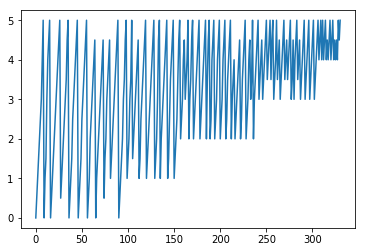

In [21]:

#features
num_tot = len(logg)
print('total number of input stars =', num_tot)
plim = 0.8
ran_frac = np.random.uniform(0,1,num_tot)
#print('ranfrac=' , ran_frac)




#Input flux data of RVS, BP, RP
x_RVStrain = norm_rvsflux[ran_frac < plim, :]
print('number of RVS training data=', len(x_RVStrain[:,0]))
x_RVScv = norm_rvsflux[ran_frac >= plim, :] #test set we left for the application

x_BPtrain = norm_bpflux[ran_frac < plim, :]
print('number of BP training data=', len(x_BPtrain[:,0]))
x_BPcv = norm_bpflux[ran_frac >= plim, :]

x_RPtrain =norm_rpflux[ran_frac < plim, :]
print('number of RP training data=', len(x_RPtrain[:,0]))
x_RPcv = norm_rpflux[ran_frac >= plim, :]


#print('x_BPtrain', x_BPtrain)

#x_train_combined = np.vstack (x_RVStrain[0,:],x_RPtrain[0,:]) 

#output label which is the logteff
y_train = logg[ran_frac< plim]
y_cv = logg[ran_frac >= plim] #test set


print('The size of CVS for the input flux data')
print('RVS cvs=', np.shape(x_RVScv))
print('BP cvs=', np.shape(x_BPcv))
print('RP cvs=', np.shape(x_RPcv))

print('the size of output label=', np.shape(y_cv) )

id = np.linspace(0, len(x_RVStrain[:, 0])-1, len(x_RVStrain[:, 0]))
plt.plot(id, y_train)
plt.show()


** Normalization **

Write a function to normalize the output labels. Each label will be normalized to have approximately have a mean of zero and unit variance.

NOTE: This is necessary to put output labels on a similar scale in order for the model to train properly, this process is reversed in the test stage to give the output labels their proper units

In [22]:
mean_labels=np.mean(logg)
std_labels=np.std(logg)
print('mean and std teff=', mean_labels, std_labels)
def normalize(labels):
    # Normalize labels
    return (labels-mean_labels) / std_labels





mean and std teff= 3.2903614457831325 1.3445664377417443


In [23]:
#normalize the y labels 
#print('y train before norm=', y_train )
y_train= normalize(y_train)
y_cv= normalize(y_cv)
#print('y train after norm=', y_train )

**Build the StarNet model architecture**

The StarNet architecture is built with:
- input layer
- 2 convolutional layers
- 1 maxpooling layer followed by flattening for the fully connected layer
- 2 fully connected layers
- output layer

First, let's define some model variables.

In [24]:
# activation function used following every layer except for the output layers
activation = 'relu'

# model weight initializer
initializer = 'he_normal'

# number of filters used in the convolutional layers
#num_filters = [4,16]
num_filters = [8,32]
#num_filters = [8,16]

# length of the filters in the convolutional layers
#filter_length = 8
#filter_length = 16
filter_length = 8

# length of the maxpooling window 
pool_length = 4

# number of nodes in each of the hidden fully connected layers
num_hidden = [256,128]
#num_hidden = [24,12]

# number of spectra fed into model at once during training
batch_size = 64

# maximum number of interations for model training
max_epochs = 200
#max_epochs = 100
#max_epochs = 150 
#max_epochs = 350
#max_epochs = 225
#max_epochs = 180
#max_epochs = 450
#max_epochs = 300
#max_epochs = 180


# initial learning rate for optimization algorithm
lr = 0.000003 #handled by Adam
    
# exponential decay rate for the 1st moment estimates for optimization algorithm
beta_1 = 0.9

# exponential decay rate for the 2nd moment estimates for optimization algorithm
beta_2 = 0.999

# a small constant for numerical stability for optimization algorithm
optimizer_epsilon = 1e-08

In [25]:
num_RVSfluxes=len(x_RVStrain[0,:]) 
print('number of RVS fluxes=', num_RVSfluxes)

num_BPfluxes=len(x_BPtrain[0,:]) 
print('number of BP fluxes=', num_BPfluxes)

num_RPfluxes=len(x_RPtrain[0,:]) 
print('number of RP fluxes=', num_RPfluxes)

num_labels= 1
print('number of training teff=', num_labels)

#ilam = np.linspace(0, num_fluxes-1, num_fluxes)
#plt.plot(ilam, x_train[329, :])
#plt.plot()

#iy = np.linspace(0, len(y_train)-1, len(y_train))
#plt.plot(iy, y_train)
#plt.plot()


number of RVS fluxes= 1134
number of BP fluxes= 53
number of RP fluxes= 49
number of training teff= 1


In [26]:

# Input RVS spectra
# print(' num_RVSfluxes=', num_RVSfluxes)
input_RVSspec = Input(shape=(num_RVSfluxes,), name='rvs_input_x' ) #removed name='starnet_input_x'

# Reshape spectra for RVS layers
cur_rvs = Reshape((num_RVSfluxes, 1))(input_RVSspec)

# CNN layers
cur_rvs = Conv1D(kernel_initializer=initializer, activation=activation, 
                padding="same", filters=num_filters[0], kernel_size=filter_length)(cur_rvs) #first CNN layer
cur_rvs = Conv1D(kernel_initializer=initializer, activation=activation,
                padding="same", filters=num_filters[1], kernel_size=filter_length)(cur_rvs) #2nd CNN layer

# Max pooling layer
cur_rvs = MaxPooling1D(pool_size=pool_length)(cur_rvs)

# Flatten the current input for the fully-connected layers
cur_rvs = Flatten()(cur_rvs)


##############################################################################################


# Input BP spectra
# print(' num_BPfluxes=', num_BPfluxes)
input_BPspec = Input(shape=(num_BPfluxes,), name='bp_input_x' ) #removed name='starnet_input_x'

# Reshape spectra for BP layers
cur_bp = Reshape((num_BPfluxes, 1))(input_BPspec)

# CNN layers
cur_bp = Conv1D(kernel_initializer=initializer, activation=activation, 
                padding="same", filters=num_filters[0], kernel_size=filter_length)(cur_bp) #first CNN layer
cur_bp = Conv1D(kernel_initializer=initializer, activation=activation,
                padding="same", filters=num_filters[1], kernel_size=filter_length)(cur_bp) #2nd CNN layer

# Max pooling layer
cur_bp = MaxPooling1D(pool_size=pool_length)(cur_bp)


# Flatten the current input for the fully-connected layers
cur_bp = Flatten()(cur_bp)


################################################################################################

# Input RP spectra
input_RPspec = Input(shape=(num_RPfluxes,), name='rp_input_x' ) #removed name='starnet_input_x'

# Reshape spectra for CNN layers
cur_rp = Reshape((num_RPfluxes, 1))(input_RPspec)

# CNN layers
cur_rp = Conv1D(kernel_initializer=initializer, activation=activation, 
                padding="same", filters=num_filters[0], kernel_size=filter_length)(cur_rp) #first CNN layer
cur_rp = Conv1D(kernel_initializer=initializer, activation=activation,
                padding="same", filters=num_filters[1], kernel_size=filter_length)(cur_rp) #2nd CNN layer

# Max pooling layer
cur_rp = MaxPooling1D(pool_size=pool_length)(cur_rp)

# Flatten the current input for the fully-connected layers
cur_rp = Flatten()(cur_rp)

###############################################################################################

#concatenate RVS/BP/RP and then insert it to dense layer 

cur_comb = concatenate([cur_rvs, cur_bp, cur_rp])

# Fully-connected layers
cur_final = Dense(units=num_hidden[0], kernel_initializer=initializer, 
               activation=activation)(cur_comb)
cur_final = Dense(units=num_hidden[1], kernel_initializer=initializer, 
               activation=activation)(cur_final)

# Output nodes
output_final = Dense(units=num_labels, activation="linear", 
                    input_dim=num_hidden[1], name='output_y')(cur_final)


model = Model(inputs = [input_RVSspec, input_BPspec, input_RPspec], outputs=output_final)






**More model techniques**
* The `Adam` optimizer is the gradient descent algorithm used for minimizing the loss function
* `EarlyStopping` uses the cross-validation set to test the model following every iteration and stops the training if the cv loss does not decrease by `min_delta` after `patience` iterations
* `ReduceLROnPlateau` is a form of learning rate decay where the learning rate is decreased by a factor of `factor` if the training loss does not decrease by `epsilon` after `patience` iterations unless the learning rate has reached `min_lr`

In [27]:
# Default loss function parameters
early_stopping_min_delta = 0.0007
early_stopping_patience = 4
reduce_lr_factor = 0.5
reuce_lr_epsilon = 0.0000009
reduce_lr_patience = 2
reduce_lr_min = 0.00008

# loss function to minimize
loss_function = 'mean_squared_error'

# compute mean absolute deviation
metrics = ['mae', 'mse']
#metrics = ['mae']

In [28]:
#optimizer = Adam(lr=lr, beta_1=beta_1, beta_2=beta_2, epsilon=optimizer_epsilon, decay=0.0)
optimizer = Adam(lr=0.005)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=early_stopping_min_delta, 
                                       patience=early_stopping_patience, verbose=2, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, epsilon=reuce_lr_epsilon, 
                                  patience=reduce_lr_patience, min_lr=reduce_lr_min, mode='min', verbose=2)

**Compile model**

In [29]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rvs_input_x (InputLayer)        (None, 1134)         0                                            
__________________________________________________________________________________________________
bp_input_x (InputLayer)         (None, 53)           0                                            
__________________________________________________________________________________________________
rp_input_x (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 1134, 1)      0           rvs_input_x[0][0]                
__________________________________________________________________________________________________
reshape_5 

**Train model**

In [30]:

#history = model.fit(x_train, y_train, validation_data=(x_cv, y_cv),
          #epochs=max_epochs, verbose=1, shuffle='batch',
         #callbacks=[early_stopping, reduce_lr])

history = model.fit([x_RVStrain, x_BPtrain, x_RPtrain], y_train, validation_data=([x_RVScv, x_BPcv, x_RPcv], y_cv),
          epochs=max_epochs, verbose=1, shuffle='batch')

Train on 331 samples, validate on 84 samples
Epoch 1/200
331/331 [==============================] - 2s 6ms/step - loss: 4913.9133 - mean_absolute_error: 29.1724 - mean_squared_error: 4913.9133 - val_loss: 13.1625 - val_mean_absolute_error: 3.4927 - val_mean_squared_error: 13.1625
Epoch 2/200
331/331 [==============================] - 0s 1ms/step - loss: 4.7609 - mean_absolute_error: 1.6923 - mean_squared_error: 4.7609 - val_loss: 1.3029 - val_mean_absolute_error: 0.9001 - val_mean_squared_error: 1.3029
Epoch 3/200
331/331 [==============================] - 0s 1ms/step - loss: 1.2552 - mean_absolute_error: 0.9145 - mean_squared_error: 1.2552 - val_loss: 1.0951 - val_mean_absolute_error: 0.8544 - val_mean_squared_error: 1.0951
Epoch 4/200
331/331 [==============================] - 1s 2ms/step - loss: 0.9372 - mean_absolute_error: 0.7980 - mean_squared_error: 0.9372 - val_loss: 0.8329 - val_mean_absolute_error: 0.7628 - val_mean_squared_error: 0.8329
Epoch 5/200
331/331 [=================

Epoch 37/200
331/331 [==============================] - 0s 1ms/step - loss: 0.4167 - mean_absolute_error: 0.5194 - mean_squared_error: 0.4167 - val_loss: 0.3536 - val_mean_absolute_error: 0.4898 - val_mean_squared_error: 0.3536
Epoch 38/200
331/331 [==============================] - 0s 1ms/step - loss: 0.2141 - mean_absolute_error: 0.3557 - mean_squared_error: 0.2141 - val_loss: 0.2367 - val_mean_absolute_error: 0.3949 - val_mean_squared_error: 0.2367
Epoch 39/200
331/331 [==============================] - 1s 2ms/step - loss: 0.1673 - mean_absolute_error: 0.3107 - mean_squared_error: 0.1673 - val_loss: 0.1932 - val_mean_absolute_error: 0.3544 - val_mean_squared_error: 0.1932
Epoch 40/200
331/331 [==============================] - 0s 1ms/step - loss: 0.1204 - mean_absolute_error: 0.2600 - mean_squared_error: 0.1204 - val_loss: 0.1146 - val_mean_absolute_error: 0.2632 - val_mean_squared_error: 0.1146
Epoch 41/200
331/331 [==============================] - 0s 1ms/step - loss: 0.0999 - mea

Epoch 73/200
331/331 [==============================] - 0s 1ms/step - loss: 0.2854 - mean_absolute_error: 0.4463 - mean_squared_error: 0.2854 - val_loss: 0.1373 - val_mean_absolute_error: 0.2887 - val_mean_squared_error: 0.1373
Epoch 74/200
331/331 [==============================] - 0s 1ms/step - loss: 0.0922 - mean_absolute_error: 0.2374 - mean_squared_error: 0.0922 - val_loss: 0.0911 - val_mean_absolute_error: 0.2231 - val_mean_squared_error: 0.0911
Epoch 75/200
331/331 [==============================] - 0s 1ms/step - loss: 0.0606 - mean_absolute_error: 0.1921 - mean_squared_error: 0.0606 - val_loss: 0.0840 - val_mean_absolute_error: 0.2080 - val_mean_squared_error: 0.0840
Epoch 76/200
331/331 [==============================] - 1s 2ms/step - loss: 0.0744 - mean_absolute_error: 0.2065 - mean_squared_error: 0.0744 - val_loss: 0.1910 - val_mean_absolute_error: 0.3736 - val_mean_squared_error: 0.1910
Epoch 77/200
331/331 [==============================] - 0s 1ms/step - loss: 0.1076 - mea

Epoch 109/200
331/331 [==============================] - 0s 1ms/step - loss: 0.1237 - mean_absolute_error: 0.2966 - mean_squared_error: 0.1237 - val_loss: 0.0724 - val_mean_absolute_error: 0.1984 - val_mean_squared_error: 0.0724
Epoch 110/200
331/331 [==============================] - 0s 1ms/step - loss: 0.0720 - mean_absolute_error: 0.2080 - mean_squared_error: 0.0720 - val_loss: 0.0800 - val_mean_absolute_error: 0.2156 - val_mean_squared_error: 0.0800
Epoch 111/200
331/331 [==============================] - 0s 1ms/step - loss: 0.0518 - mean_absolute_error: 0.1826 - mean_squared_error: 0.0518 - val_loss: 0.0756 - val_mean_absolute_error: 0.2085 - val_mean_squared_error: 0.0756
Epoch 112/200
331/331 [==============================] - 0s 1ms/step - loss: 0.0540 - mean_absolute_error: 0.1841 - mean_squared_error: 0.0540 - val_loss: 0.1417 - val_mean_absolute_error: 0.3189 - val_mean_squared_error: 0.1417
Epoch 113/200
331/331 [==============================] - 1s 2ms/step - loss: 0.0806 

Epoch 145/200
331/331 [==============================] - 0s 1ms/step - loss: 0.0602 - mean_absolute_error: 0.1912 - mean_squared_error: 0.0602 - val_loss: 0.0674 - val_mean_absolute_error: 0.1886 - val_mean_squared_error: 0.0674
Epoch 146/200
331/331 [==============================] - 0s 1ms/step - loss: 0.0625 - mean_absolute_error: 0.2032 - mean_squared_error: 0.0625 - val_loss: 0.1364 - val_mean_absolute_error: 0.3009 - val_mean_squared_error: 0.1364
Epoch 147/200
331/331 [==============================] - 0s 1ms/step - loss: 0.0627 - mean_absolute_error: 0.1974 - mean_squared_error: 0.0627 - val_loss: 0.0798 - val_mean_absolute_error: 0.2195 - val_mean_squared_error: 0.0798
Epoch 148/200
331/331 [==============================] - 0s 1ms/step - loss: 0.0428 - mean_absolute_error: 0.1553 - mean_squared_error: 0.0428 - val_loss: 0.0834 - val_mean_absolute_error: 0.2231 - val_mean_squared_error: 0.0834
Epoch 149/200
331/331 [==============================] - 1s 2ms/step - loss: 0.0551 

Epoch 181/200
331/331 [==============================] - 0s 1ms/step - loss: 0.0376 - mean_absolute_error: 0.1490 - mean_squared_error: 0.0376 - val_loss: 0.1078 - val_mean_absolute_error: 0.2659 - val_mean_squared_error: 0.1078
Epoch 182/200
331/331 [==============================] - 0s 1ms/step - loss: 0.0748 - mean_absolute_error: 0.2263 - mean_squared_error: 0.0748 - val_loss: 0.2656 - val_mean_absolute_error: 0.4543 - val_mean_squared_error: 0.2656
Epoch 183/200
331/331 [==============================] - 0s 1ms/step - loss: 0.1994 - mean_absolute_error: 0.3751 - mean_squared_error: 0.1994 - val_loss: 0.2363 - val_mean_absolute_error: 0.4206 - val_mean_squared_error: 0.2363
Epoch 184/200
331/331 [==============================] - 1s 2ms/step - loss: 0.1184 - mean_absolute_error: 0.2783 - mean_squared_error: 0.1184 - val_loss: 0.4111 - val_mean_absolute_error: 0.5787 - val_mean_squared_error: 0.4111
Epoch 185/200
331/331 [==============================] - 0s 1ms/step - loss: 0.1792 

In [31]:
hist = pd.DataFrame(history.history)
hist['epoch']= history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
195,0.170063,0.340025,0.170063,0.138289,0.313115,0.138289,195
196,0.071767,0.209120,0.071767,0.056825,0.198725,0.056825,196
197,0.080048,0.220671,0.080048,0.039128,0.155708,0.039128,197
198,0.164552,0.341280,0.164552,0.054494,0.189182,0.054494,198
199,0.087476,0.235719,0.087476,0.067435,0.204755,0.067435,199


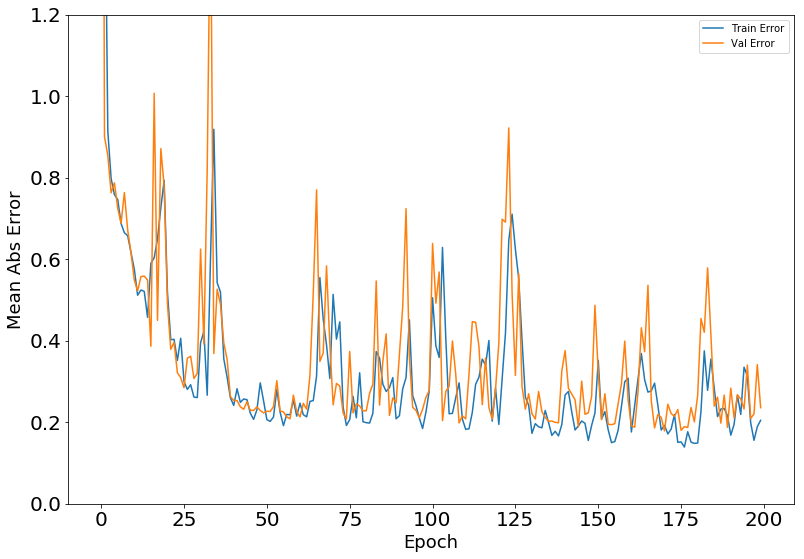

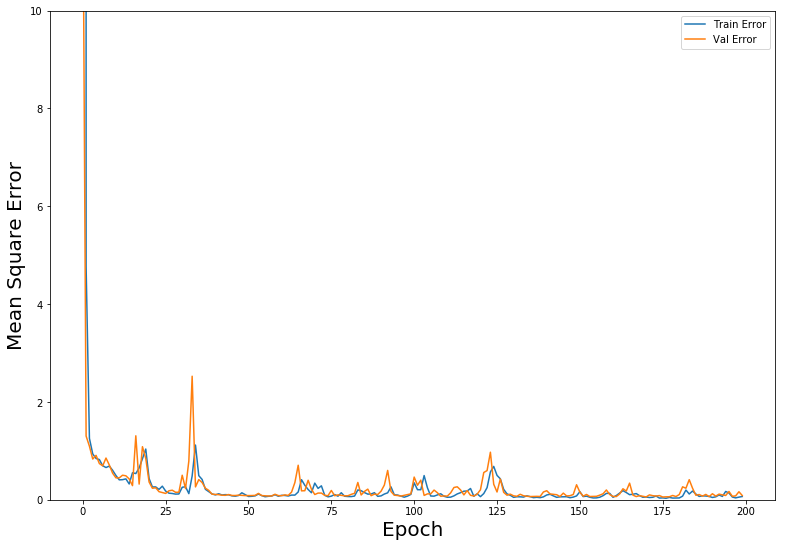

In [32]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
    
  plt.figure(figsize=(13,9))
  #plt.figure()
  plt.xlabel('Epoch', fontsize= 18)
  plt.ylabel('Mean Abs Error', fontsize= 18)
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,1.2])
  plt.tick_params(labelsize=20)
  plt.legend()
  

  plt.figure(figsize=(13,9))
  #plt.figure()
  plt.xlabel('Epoch', fontsize = 20)
  plt.ylabel('Mean Square Error', fontsize= 20)
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,10])
  plt.legend()
  plt.show()


plot_history(history)

**Save model**

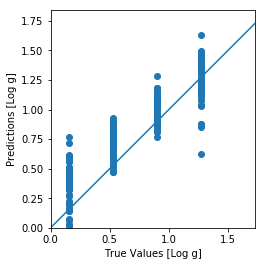

In [33]:
test_predictions = model.predict([norm_rvsflux, norm_bpflux, norm_rpflux]).flatten()

plt.scatter(normalize(logg), test_predictions)
plt.xlabel('True Values [Log g]')
plt.ylabel('Predictions [Log g]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

#print('test predictions=', test_predictions)

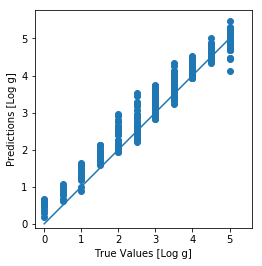

In [34]:
#Unnormalizing the labels (teff)

def denormalize (labels):
    return (((labels)*(std_labels)) + mean_labels)


test_predictions = model.predict([norm_rvsflux, norm_bpflux, norm_rpflux]).flatten()
plt.scatter(logg, denormalize(test_predictions))
plt.xlabel('True Values [Log g]')
plt.ylabel('Predictions [Log g]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([0, 5 ], [0, 5])

#print('test predictions=', test_predictions)







(0, 5.744837425876998)

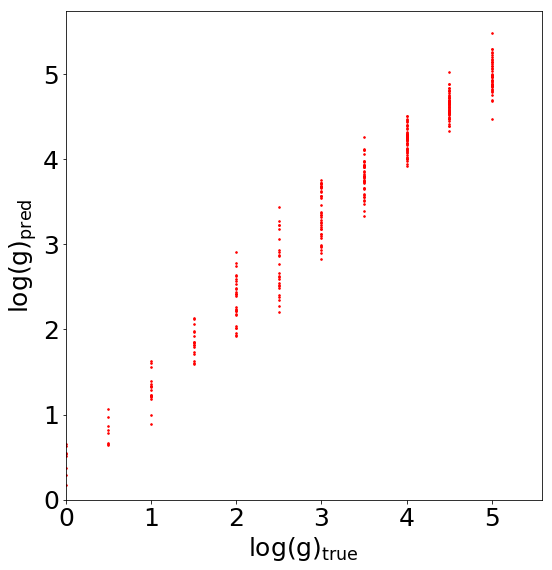

In [36]:
#Unnormalizing the labels (teff)

def denormalize (labels):
    return (((labels)*(std_labels)) + mean_labels)

plt.figure(figsize=(13,9))
test_predictions = model.predict([x_RVStrain, x_BPtrain, x_RPtrain]).flatten()
plt.scatter(denormalize(y_train), denormalize(test_predictions), c= 'r', s= 2.5)
plt.xlabel(r"$\rm log(g)_{\rm true}$", fontsize=25)
plt.ylabel(r"$\rm log(g)_{\rm pred}$", fontsize=25)
plt.axis('equal')
plt.axis('square')
# increase the x,y tick label size
plt.tick_params(labelsize= 25) 
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([-100, 100], [-100, 100])
#print('test predictions=', test_predictions)



standard deviation 331


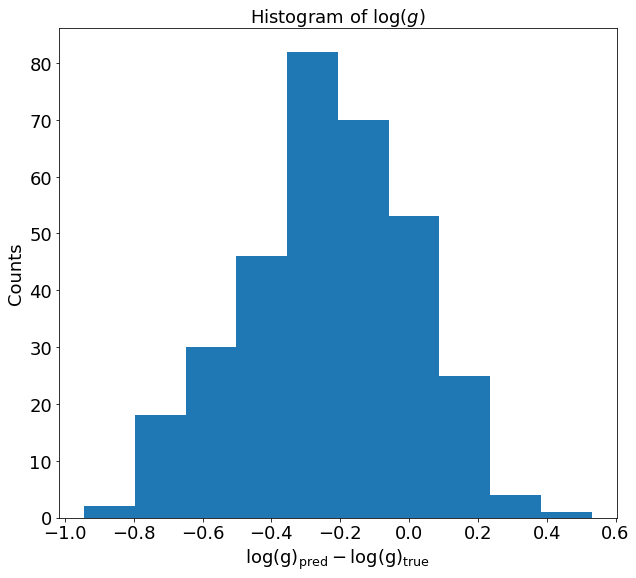

In [37]:
#Making the histogram of denormalized training set 

plt.figure(figsize=(10,9))
z=np.subtract(denormalize(y_train), denormalize(test_predictions)) #difference between the true and predicted values
counts, bins = np.histogram(z)
plt.hist(bins[:-1], bins, weights=counts)

# increase the x,y tick label size
plt.tick_params(labelsize=18) 
plt.title(r'Histogram of $\log(g)$', fontsize=18)
plt.xlabel(r"$\rm log(g)_{pred}-\rm log(g)_{true}$ ", fontsize=18)
plt.ylabel('Counts', fontsize=18)

print('standard deviation', len(z))
#print(len(z[teff<5000]))
#print(len(z))


# Training Data Set

In [42]:
# getting deviation in Teff bins
nbin = 4
teffbin_edges=np.array([0, 2, 4, 6])

# pred vs. true
# unnormalised values
teff_pred = denormalize(test_predictions)
teff_true = denormalize(y_train) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
teff_diff = teff_pred-teff_true

# compute mean and std in Teff bins
teff_diff_mean = np.zeros(nbin) 
teff_diff_std = np.zeros(nbin)
teffbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(teff_true<teffbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(teff_true>teffbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((teff_true>teffbin_edges[i-1]) & (teff_true<teffbin_edges[i]))
        #if i=1, teff_true>(teffbin_edges[1-1=0]= 5000) & teff_true<teffbin_edges[1]= 10000, so 5000<teff<10000
        #if i=2, teff_true>(teffbin_edges[2-1=1]=10000) & teff_true<teffbin_edges[2]= 15000, so 10000<teff<15000
        #if i=3, teff_true> (teffbin_edges[3-1=2]= 15000) & teff_true<teffbin_edges[3]= 20000 so 15000<teff<20000
    teffbin_mean[i] = np.mean(teff_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    teff_diff_mean[i] = np.mean(teff_diff[indx]) #calculating the mean values of teff_diff from its index 
    teff_diff_std[i] = np.std(teff_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin teff_true=', teffbin_mean)
print('mean of teff_diff=', teff_diff_mean)
print('std of teff_diff=', teff_diff_std)
print('length of teff_diff=', len(teff_diff))




mean of bin teff_true= [-4.44089210e-16  1.10714286e+00  3.08571429e+00  4.72959184e+00]
mean of teff_diff= [0.46689641 0.31931555 0.31100045 0.06676866]
std of teff_diff= [0.15918454 0.17109208 0.27102644 0.1791565 ]
length of teff_diff= 331


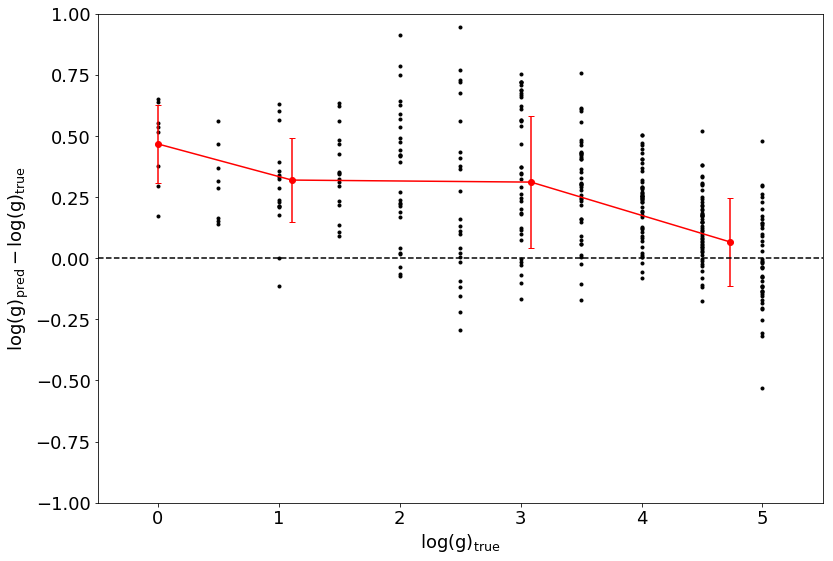

In [43]:
# plot
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(teff_true, teff_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(teffbin_mean,teff_diff_mean, yerr=teff_diff_std, fmt='-o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=18) 

# set x, y label. 
plt.xlabel(r"$T_{\rm eff,true}$ (K)", fontsize=18)
plt.ylabel(r"$T_{\rm eff,pred}-T_{\rm eff,true}$ (K)", fontsize=18)

# set x, y lim plot range
xlim=np.array([-0.5,5.5])
ylim=np.array([-1.0,1.0])
plt.xlim(xlim[0],xlim[1]) #plotting the xlim
plt.ylim(ylim[0],ylim[1])

# set x, y label. 
plt.xlabel(r"$\rm log(g)_{\rm true}$", fontsize=18)
plt.ylabel(r"$\rm log(g)_{\rm pred}-\rm log(g)_{\rm true}$", fontsize=18)

# draw y=0 line
xline = np.linspace(xlim[0],xlim[1], 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')





# Cross Validation Set

len of y_cv= 84


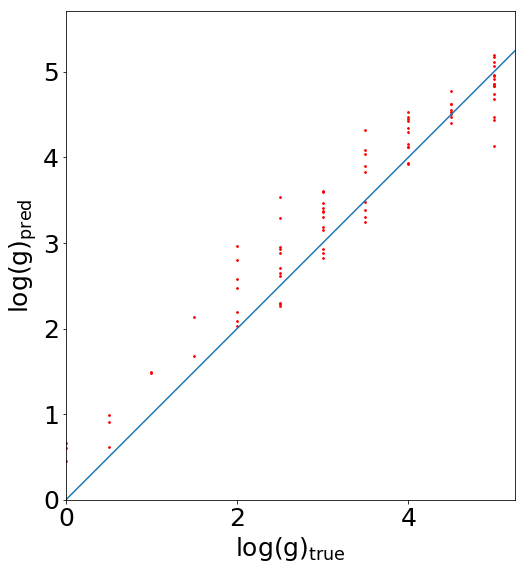

In [44]:
#Test set (x_cv)

plt.figure(figsize=(13,9))
cv_predictions = model.predict([x_RVScv, x_BPcv, x_RPcv]).flatten()
plt.scatter(denormalize(y_cv), denormalize(cv_predictions), c= 'r', s= 3)
plt.xlabel(r"$\rm log(g)_{\rm true}$", fontsize=25)
plt.ylabel(r"$\rm log(g)_{\rm pred}$", fontsize=25)
plt.axis('equal')
plt.axis('square')
# increase the x,y tick label size
plt.tick_params(labelsize=25) 
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

#print('test predictions=', test_predictions)

print('len of y_cv=', len(y_cv))




In [45]:
# getting deviation in Teff bins
nbin = 5
teffbin_edges=np.array([ 1, 2, 3, 4, 5])

# pred vs. true
# unnormalised values
teff_pred = denormalize(cv_predictions)
teff_true = denormalize(y_cv) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
teff_diff = teff_pred-teff_true

# compute mean and std in Teff bins
teff_diff_mean = np.zeros(nbin) 
teff_diff_std = np.zeros(nbin)
teffbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(teff_true<teffbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(teff_true>teffbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((teff_true>teffbin_edges[i-1]) & (teff_true<teffbin_edges[i]))
        #if i=1, teff_true>(teffbin_edges[1-1=0]= 5000) & teff_true<teffbin_edges[1]= 10000, so 5000<teff<10000
        #if i=2, teff_true>(teffbin_edges[2-1=1]=10000) & teff_true<teffbin_edges[2]= 15000, so 10000<teff<15000
        #if i=3, teff_true> (teffbin_edges[3-1=2]= 15000) & teff_true<teffbin_edges[3]= 20000 so 15000<teff<20000
    teffbin_mean[i] = np.mean(teff_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    teff_diff_mean[i] = np.mean(teff_diff[indx]) #calculating the mean values of teff_diff from its index 
    teff_diff_std[i] = np.std(teff_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin teff_true=', teffbin_mean)
print('mean of teff_diff=', teff_diff_mean)
print('std of teff_diff=', teff_diff_std)
print('len of teff_diff=', len(teff_diff))


        

mean of bin teff_true= [0.25       1.5        2.5        3.5        4.83333333]
mean of teff_diff= [ 0.45553287  0.4069382   0.26619083  0.23297026 -0.09444831]
std of teff_diff= [0.17619091 0.23110044 0.39183721 0.36748775 0.25884615]
len of teff_diff= 84


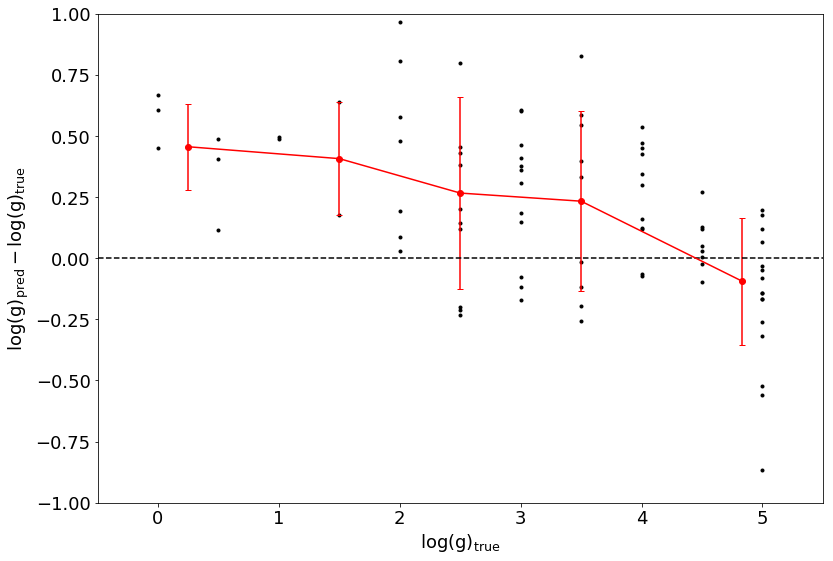

In [46]:
# plot
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(teff_true, teff_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(teffbin_mean,teff_diff_mean, yerr=teff_diff_std, fmt='-o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=18) 

# set x, y label. 
#plt.xlabel(r"$T_{\rm g,true}$ (K)", fontsize=25)
#plt.ylabel(r"$T_{\rm g,pred}-T_{\rm g,true}$ (K)", fontsize=25)

# set x, y lim plot range
xlim=np.array([-0.5, 5.5])
ylim=np.array([-1,1])
plt.xlim(xlim[0],xlim[1]) #plotting the xlim
plt.ylim(ylim[0],ylim[1])

# set x, y label. 
plt.xlabel(r"$\rm log(g)_{\rm true}$", fontsize=18)
plt.ylabel(r"$\rm log(g)_{\rm pred}-\rm log(g)_{\rm true}$", fontsize=18)

# draw y=0 line
xline = np.linspace(xlim[0],xlim[1], 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')







standard deviation 84


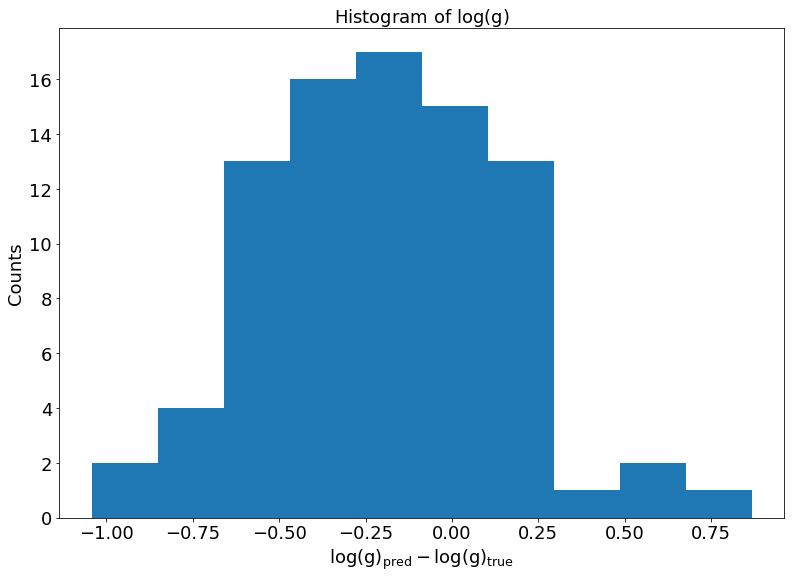

In [47]:
#Making the histogram of the CV set 

plt.figure(figsize=(13,9))
z=np.subtract(denormalize(y_cv), denormalize(cv_predictions)) #difference between the true and predicted values
counts, bins = np.histogram(z)
plt.hist(bins[:-1], bins, weights=counts)


# increase the x,y tick label size
plt.tick_params(labelsize=18) 

plt.title(r'Histogram of $\log(\rm g)$', fontsize=18)
plt.xlabel(r"$\rm log(g)_{\rm pred}-\rm log(g)_{\rm true}$", fontsize=18)
plt.ylabel('Counts', fontsize=18)
#z[teff<5000].std()
print('standard deviation', len(z))
#print(len(z[teff<5000]))
#print(len(z))



In [62]:
# Input spectra
input_spec = Input(shape=(num_fluxes,), name='starnet_input_x')

# Reshape spectra for CNN layers
cur_in = Reshape((num_fluxes, 1))(input_spec)

# CNN layers
# First
cur_in = Conv1D(kernel_initializer=initializer, activation=activation, 
                padding="same", filters=128, kernel_size=32)(cur_in) #first CNN layer
# Max pooling layer
cur_in = MaxPooling1D(pool_size=32)(cur_in)
# Second CNN layer
cur_in = Conv1D(kernel_initializer=initializer, activation=activation,
                padding="same", filters=128, kernel_size=16)(cur_in) #2nd CNN layer
# Max pooling layer
cur_in = MaxPooling1D(pool_size=16)(cur_in)
# Third CNN layer
cur_in = Conv1D(kernel_initializer=initializer, activation=activation,
                padding="same", filters=128, kernel_size=8)(cur_in) #2nd CNN layer
# Max pooling layer
cur_in = MaxPooling1D(pool_size=8)(cur_in)

# Flatten the current input for the fully-connected layers
cur_in = Flatten()(cur_in)

# Fully-connected layers
cur_in = Dense(units=258, kernel_initializer=initializer, 
               activation=activation)(cur_in)
cur_in = Dense(units=128, kernel_initializer=initializer, 
               activation=activation)(cur_in)

# Output nodes
output_label = Dense(units=num_labels, kernel_regularizer=keras.regularizers.l2(0.01), activation="linear", 
                     input_dim=num_hidden[1])(cur_in)

model = Model(input_spec, output_label)

NameError: name 'num_fluxes' is not defined

In [16]:
optimizer = Adam(lr=0.0005)

In [97]:
# loss function to minimize
loss_function = 'mean_squared_error'
optimizer = 'adadelta'
# compute mean absolute deviation
metrics = ['mae', 'mse']
#metrics = ['mae']
model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
starnet_input_x (InputLayer) (None, 6758)              0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 6758, 1)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 6758, 128)         4224      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 211, 128)          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 211, 128)          262272    
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 13, 128)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 13, 128)           131200    
__________

In [ ]:
history = model.fit(x_train, y_train, 
          epochs=max_epochs, validation_split = 0.2, verbose=1, shuffle='batch')

Train on 875 samples, validate on 219 samples
Epoch 1/200
875/875 [==============================] - 13s 15ms/step - loss: 5.2174 - mean_absolute_error: 1.4147 - mean_squared_error: 5.1988 - val_loss: 1.5482 - val_mean_absolute_error: 0.9417 - val_mean_squared_error: 1.5305
Epoch 2/200
875/875 [==============================] - 12s 14ms/step - loss: 0.3955 - mean_absolute_error: 0.5094 - mean_squared_error: 0.3783 - val_loss: 1.8217 - val_mean_absolute_error: 1.0313 - val_mean_squared_error: 1.8050
Epoch 3/200
875/875 [==============================] - 12s 14ms/step - loss: 0.3606 - mean_absolute_error: 0.4579 - mean_squared_error: 0.3443 - val_loss: 1.9750 - val_mean_absolute_error: 1.0742 - val_mean_squared_error: 1.9589
Epoch 4/200
875/875 [==============================] - 12s 14ms/step - loss: 0.3806 - mean_absolute_error: 0.4960 - mean_squared_error: 0.3648 - val_loss: 2.0388 - val_mean_absolute_error: 1.0894 - val_mean_squared_error: 2.0232
Epoch 5/200
875/875 [=================

Epoch 72/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0399 - mean_absolute_error: 0.1346 - mean_squared_error: 0.0361 - val_loss: 1.6221 - val_mean_absolute_error: 0.9613 - val_mean_squared_error: 1.6183
Epoch 73/200
875/875 [==============================] - 13s 14ms/step - loss: 0.0413 - mean_absolute_error: 0.1380 - mean_squared_error: 0.0375 - val_loss: 1.5695 - val_mean_absolute_error: 0.9410 - val_mean_squared_error: 1.5657
Epoch 74/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0508 - mean_absolute_error: 0.1554 - mean_squared_error: 0.0470 - val_loss: 1.6579 - val_mean_absolute_error: 0.9698 - val_mean_squared_error: 1.6541
Epoch 75/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0419 - mean_absolute_error: 0.1415 - mean_squared_error: 0.0381 - val_loss: 1.9499 - val_mean_absolute_error: 1.0596 - val_mean_squared_error: 1.9461
Epoch 76/200
875/875 [==============================] - 12s 14ms/step - loss: 0.

875/875 [==============================] - 12s 13ms/step - loss: 0.0267 - mean_absolute_error: 0.1066 - mean_squared_error: 0.0241 - val_loss: 1.3541 - val_mean_absolute_error: 0.8321 - val_mean_squared_error: 1.3514
Epoch 143/200
875/875 [==============================] - 13s 14ms/step - loss: 0.0540 - mean_absolute_error: 0.1430 - mean_squared_error: 0.0514 - val_loss: 1.8749 - val_mean_absolute_error: 1.0292 - val_mean_squared_error: 1.8723
Epoch 144/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0324 - mean_absolute_error: 0.1221 - mean_squared_error: 0.0298 - val_loss: 1.3159 - val_mean_absolute_error: 0.8185 - val_mean_squared_error: 1.3133
Epoch 145/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0255 - mean_absolute_error: 0.0968 - mean_squared_error: 0.0230 - val_loss: 1.3150 - val_mean_absolute_error: 0.8193 - val_mean_squared_error: 1.3124
Epoch 146/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0254 - me

In [32]:
hist = pd.DataFrame(history.history)
hist['epoch']= history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
195,6.650632e+07,6355.818481,6.650632e+07,1.702399e+06,881.769361,1.702399e+06,195
196,6.275853e+07,6161.197162,6.275853e+07,1.711892e+06,930.596856,1.711892e+06,196
197,5.944006e+07,5997.135702,5.944006e+07,1.580298e+06,893.164042,1.580298e+06,197
198,6.229281e+07,6138.579988,6.229281e+07,1.912179e+06,979.157146,1.912179e+06,198
199,6.106594e+07,6076.085226,6.106594e+07,1.614590e+06,912.569914,1.614590e+06,199


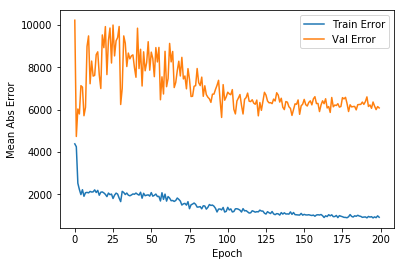

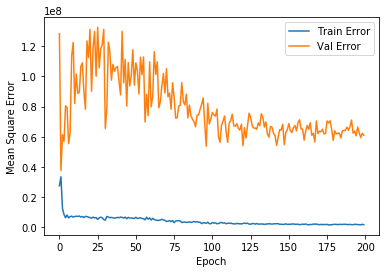

In [33]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

test predictions= [ 6836.807   6837.5747  6836.7603 ... 10159.98   12968.633  12631.623 ]


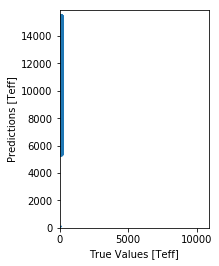

In [34]:
test_predictions = model.predict(norm_flux).flatten()

plt.scatter(normalize(teff), test_predictions)
plt.xlabel('True Values [Teff]')
plt.ylabel('Predictions [Teff]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

print('test predictions=', test_predictions)